<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/ce/Huberlin-logo.svg/200px-Huberlin-logo.svg.png" alt="fff" align="left" style="width: 150px;width: 150px;align:left">


# Transformer
 
#### Thesis: Neural response generation for email conversations
#### Author: Sydney Richards
#### Required Runtime: GPU
#### Tensorflow version required 2.x






This notebook restores the previously trained Transformer models for the English Data Set only since setting up the decoder for both languages would not have been feasible.However, both a decoder using greedy seach as well as beam search are implemented in this workbook. Also, it might be necessary to adjusted the paths of file imports, e.g. for the tokenizer or saved GLOVE embeddings. Ideally, users can quickly restore the models presented in the thesis in order to interact with them to familiarize themselves with the set up.



###Contents:

##### [1.System Set Up & File Import](#setup)
##### [2.Build Transformer Model](#build)
- [Positional Enconging](#pos)
- [Masking](#mask)
- [Scaled Dot Attention](#dot)
- [Multi Head Attention](#head)
- [FFNN](#ffnn)
- [Encoder Layer](#encL)
- [Decoder Layer](#decL)
- [Encoder](#enc)
- [Decoder](#dec)
- [Putting it together](#end)

##### [3.Restore Checkpoints](#check)
##### [4.Generate Responses](#gen)

- [Greedy Decoder](#greedy)
- [Beam Search](#beam)

## 1. System Set Up & File Import
<a id='setup'></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
#import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
import datetime as dt
import pandas as pd


seed = np.random.RandomState(seed=10)

TensorFlow 2.x selected.


In [2]:
!pip install nltk --upgrade

Requirement already up-to-date: nltk in /usr/local/lib/python3.6/dist-packages (3.4.5)


In [3]:
import nltk

#!wget 'https://nlp.stanford.edu/software/stanford-corenlp-full-2018-10-05.zip'
#!unzip stanford-corenlp-full-2018-10-05

nltk.download('punkt')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
os.getcwd()

'/content'

In [0]:
MAX_LENGTH = 50 

In [0]:
with open("/content/drive/My Drive/Master Thesis/Submission/input_tokenizer.txt", "r") as text_file:
  data = text_file.readline()
input_tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)

with open("/content/drive/My Drive/Master Thesis/Submission/target_tokenizer.txt", "r") as text_file:
  data = text_file.readline()
target_tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)


with open("/content/drive/My Drive/Master Thesis/Submission/input_tokenizer_DE.txt", "r") as text_file:
  data = text_file.readline()
input_tokenizerDE = tf.keras.preprocessing.text.tokenizer_from_json(data)

with open("/content/drive/My Drive/Master Thesis/Submission/target_tokenizer_DE.txt", "r") as text_file:
  data = text_file.readline()
target_tokenizerDE = tf.keras.preprocessing.text.tokenizer_from_json(data)

In [8]:
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [0]:
enc_num_layers = 6
dec_num_layers = 6
d_model = 256
dff = 1024
num_heads = 8

input_vocab_size = len(input_tokenizer.word_index) + 2
target_vocab_size = len(target_tokenizer.word_index) + 2
dropout_rate = 0.1

In [0]:
embeddings_matrixGlove = np.load('/content/drive/My Drive/Master Thesis/Submission/embedding10.npy')

## 2. Build Transformer model
<a id='build'></a>

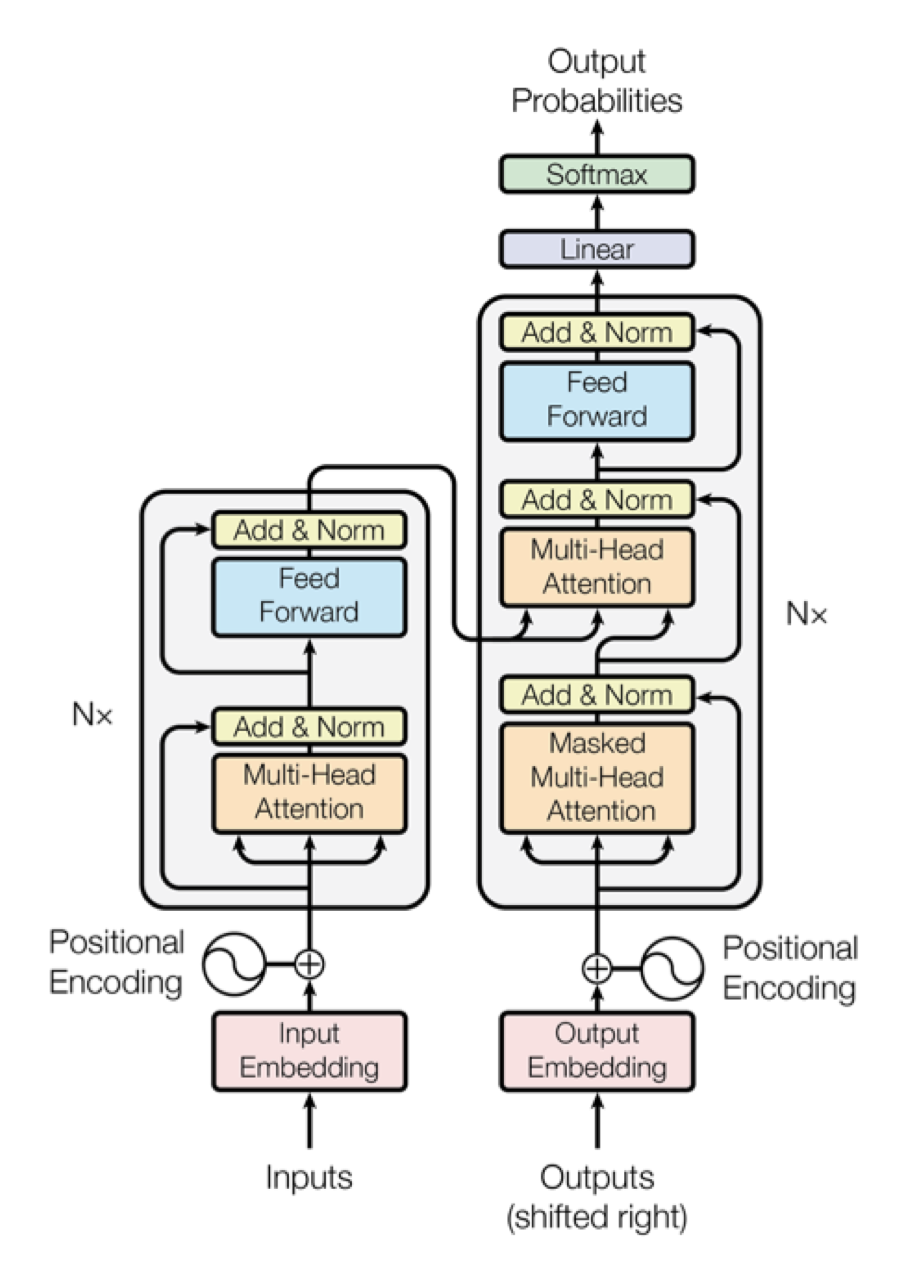

In [48]:
from IPython.display import Image
Image('/content/drive/My Drive/Master Thesis/Submission/Notebooks/figures/Transformer.png', width=400, height=500)

## Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [0]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [0]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

### Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [0]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [0]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

### Scaled Dot Product Attention



The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `Q` and `K` should have a mean of 0 and variance of 1, and you get a gentler softmax.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

In [0]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

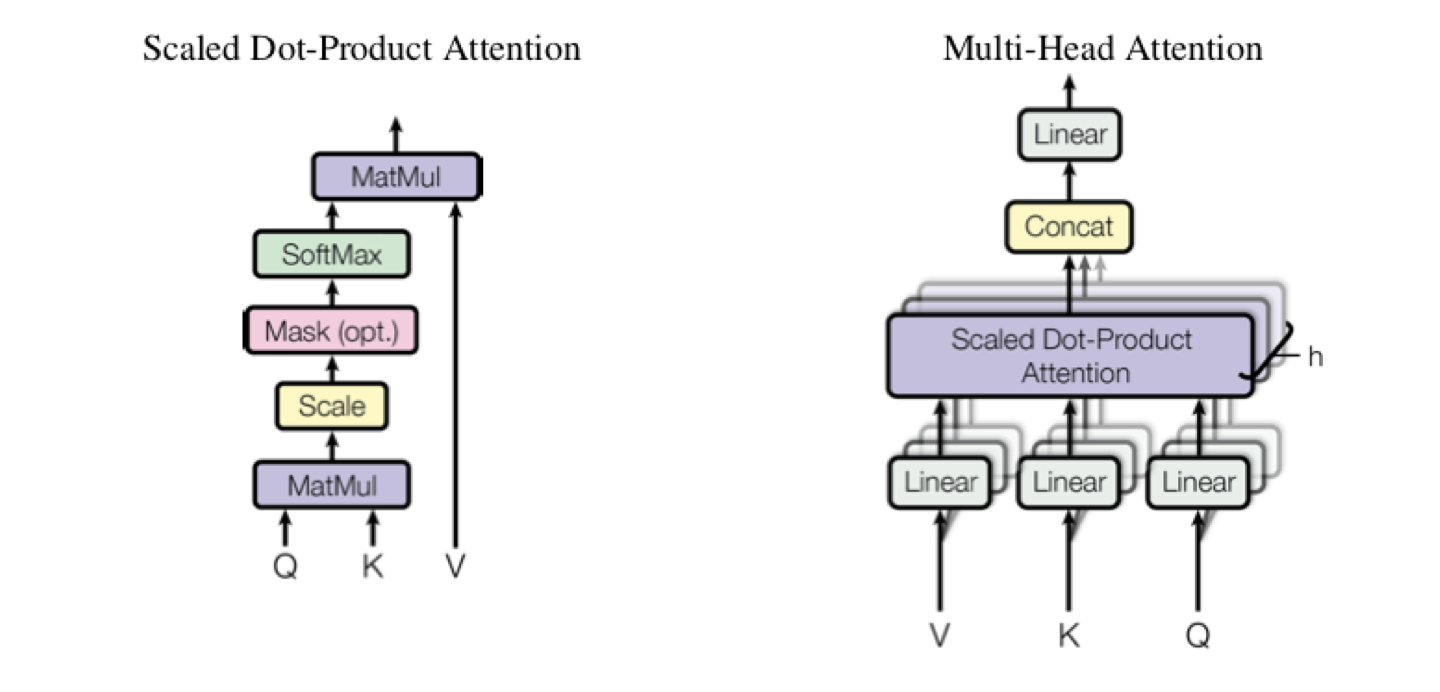

In [50]:
from IPython.display import Image
Image('/content/drive/My Drive/Master Thesis/Submission/Notebooks/figures/attention.png',width=700, height=350)

## Multi-head attention



Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [0]:
class PointWiseFFN(tf.keras.layers.Layer):
  def __init__(self,d_model,dff):
    super(PointWiseFFN,self).__init__()
    self.d_model = d_model
    self.dff = dff

    self.d1 = tf.keras.layers.Dense(dff,activation='relu')
    self.drop = tf.keras.layers.Dropout(0.2)
    self.d2 = tf.keras.layers.Dense(d_model)

  def call(self,x):
    x = self.d1(x)
    x = self.drop(x)
    output = self.d2(x)

    return output

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [0]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = PointWiseFFN(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [0]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = PointWiseFFN(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [0]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size
                                              ,d_model
                                              ,embeddings_initializer=
                                               tf.keras.initializers.Constant(embeddings_matrixGlove))
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

## 
The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.


In [0]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

## Create the Transformer
Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [0]:
class Transformer(tf.keras.Model):
  def __init__(self, enc_num_layers,dec_num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(enc_num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(dec_num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [0]:

transformer = Transformer(enc_num_layers,dec_num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [0]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

## Optimizer
Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)
optimizerTR = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                      epsilon=1e-9)

## 3. Restore Checkpoints
<a id='check'></a>

In [28]:
checkpoint_path = "/content/drive/My Drive/Master Thesis/Submission/Checkpoints/training_checkpoints_TR_EN"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizerTR)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=4)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Transformer restored!!')

Transformer restored!!


In [0]:
#checkpoint_pathDE = "/content/drive/My Drive/Master Thesis/Checkpoints/training_checkpoints_TR_DE"

#ckptDE = tf.train.Checkpoint(transformer=transformerDE,
#                           optimizer=optimizerTR)

#ckpt_managerDE = tf.train.CheckpointManager(ckptDE, checkpoint_pathDE, max_to_keep=4)

# if a checkpoint exists, restore the latest checkpoint.
#if ckpt_managerDE.latest_checkpoint:
 # ckptDE.restore(ckpt_managerDE.latest_checkpoint)
 # print ('German Transformer restored!!')

## Inference

In [0]:
  def preprocess_sentence(w,is_input=False):
      #w = unicode_to_ascii(w.lower().strip())

      # creating a space between a word and the punctuation following it
      # eg: "he is a boy." => "he is a boy ."
      # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
      w = w.lower().strip()
      w = re.sub(r"([?.!,¿])", r" \1 ", w)
      w = re.sub(r'[" "]+', " ", w)
      w = w.replace('\n', ' ').replace('\r', ' ').replace('\xa0',' ')
      if is_input == True:
      # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
        w = re.sub(r"[^a-zA-Z?.!,0-9]+", " ", w)
      w = w.replace('car2go','<company>')
      w = w.replace('Share Now','<company>')

      w = w.rstrip().strip()

      # adding a start and an end token to the sentence
      # so that the model know when to start and stop predicting.
      w = '<start> ' + w + ' <end>'
      return w

In [0]:
def evaluateTR(sentence):
    sentence = preprocess_sentence(sentence)

    inputs = [input_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=MAX_LENGTH,
                                                           padding='post')
    encoder_input = tf.convert_to_tensor(inputs)
    
    output = tf.expand_dims([target_tokenizer.word_index['<start>']], 0)

    for i in range(MAX_LENGTH):

      enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
          encoder_input, output)
      # predictions.shape == (batch_size, seq_len, vocab_size)
      predictions, attention_weights = transformer(encoder_input, 
                                                  output,
                                                  False,
                                                  enc_padding_mask,
                                                  combined_mask,
                                                  dec_padding_mask)
      

      # select the last word from the seq_len dimension
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
    
      # greedy decoder
      # Argmax for each iteration
      # cast function to reduce dim and get id
      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      #predicted_id = tf.cast(tf.random.categorical(predictions[:,-1,:], num_samples=1),tf.int32)
      
      # return the result if the predicted_id is equal to the end token
      if predicted_id == target_tokenizer.word_index['<end>']:
        return tf.squeeze(output, axis=0), attention_weights
      
      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [0]:
def takeProbs(elem):
    return elem[0]

In [0]:
def evaluate_beam(sentence,beam_size):
  
  sentence = preprocess_sentence(sentence)

  inputs = [input_tokenizer.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=MAX_LENGTH,
                                                           padding='post')
  encoder_input = tf.convert_to_tensor(inputs)
    
  output = tf.expand_dims([target_tokenizer.word_index['<start>']], 0)


  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
    encoder_input, output)

  # predictions.shape == (batch_size, seq_len, vocab_size)
  predictions, attention_weights = transformer(encoder_input, 
                                              output,
                                              False,
                                              enc_padding_mask,
                                              combined_mask,
                                              dec_padding_mask)

  # select the last word from the seq_len dimension
  predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
  # greedy decoder
  # Argmax for each iteration
  # cast function to reduce dim and get id
  predictid_probs , predicted_ids = tf.math.top_k(predictions,k=beam_size)
  candidates = []
  for j in range(beam_size):
    candidates.append((tf.math.log(predictid_probs[:,:,j]),predicted_ids[:,:,j]))
  for i in range(MAX_LENGTH):
    for l in range(len(candidates)): # Cand you loop over tensorlike this
        #all_canidates.remove(candidate)
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, candidates[l][1])

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                      candidates[l][1],
                                                      False,
                                                      enc_padding_mask,
                                                      combined_mask,
                                                      dec_padding_mask)
        predictions = predictions[: ,-1:, :]
        predictid_probs , predicted_ids = tf.math.top_k(predictions,k=beam_size)
        for j in range(beam_size):
          candidates.append((tf.math.add(candidates[l][0],tf.math.log(predictid_probs[:,:,j])),tf.concat([candidates[l][1] ,predicted_ids[:,:,j]],axis=-1)))
          #all_candidates.append((tf.math.add(candidates[l][0],tf.math.log(predictid_probs[:,:,j])),tf.concat([candidates[l][1] ,predicted_ids[:,:,j]],axis=-1)))
    candidates.sort(key=takeProbs)
    candidates = candidates[-beam_size:]


  return tf.squeeze(candidates[-1][1], axis=0), attention_weights

In [0]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

In [0]:
def preprocess_response(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = w.lower().strip()
    w = w.replace(' .','.').replace(' ,',',').replace(' !','!').replace(' ?','?').replace(' !','!').replace('<start> ','')
    #w = re.sub(r"([?.!,¿])", r"\1", w)


    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    #w = '<start> ' + w + ' <end>'
    return w

In [0]:
def plot_attention_weights(attention_weights,inputs,results,layer):
  fig = plt.figure(figsize=(16, 8))

  #sentence = tokenizer_pt.encode(sentence)

  attention = tf.squeeze(attention_weights[layer], axis=0)

  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:, :len(inputs)+2], cmap='Blues')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(inputs)+2))
    ax.set_yticks(range(len(results)+1))
    
    ax.set_ylim(len(results)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[i for i in inputs]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([i for i in results if i!='<start>'] , 
                        fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))

  plt.tight_layout()
  #plt.savefig('/content/drive/My Drive/Master Thesis/transromferAtn.png')
  plt.show()

In [0]:
def respondTR(sentence, plot=''):
  result, attention_weights = evaluateTR(sentence)
  
  predicted_sentence = ' '.join([target_tokenizer.index_word[i] for i in result.numpy() 
                                            if i < len(target_tokenizer.word_index)])


  inputs = [i for i in sentence.split(' ')]
  results = [target_tokenizer.index_word[i] for i in result.numpy()]

  print('Input: {}'.format(sentence))
  print('Predicted Response: {}'.format(preprocess_response(predicted_sentence)))
  
  if plot:
    plot_attention_weights(attention_weights, inputs, results, plot)

In [0]:
def decode_beam_result(result):
  decoded_sentence = []
  for i in result.numpy():
    if i < len(target_tokenizer.word_index):
      decoded_sentence.append(target_tokenizer.index_word[i])
    if target_tokenizer.index_word[i] == '<end>':
      return ' '.join(decoded_sentence)
  return ' '.join(decoded_sentence)

In [0]:
def respond_beam(sentence,beam_size, plot=''):
  result, attention_weights = evaluate_beam(sentence,beam_size)
  
  predicted_sentence = decode_beam_result(result)


  inputs = [i for i in sentence.split(' ')]
  results = [target_tokenizer.index_word[i] for i in result.numpy()]

  print('Input: {}'.format(sentence))
  print('Predicted Response: {}'.format(preprocess_response(predicted_sentence)))
  
  if plot:
    plot_attention_weights(attention_weights, inputs, results, plot)

Some enquiry suggestions which are typical for the domain:

- Please cancel my account and remove all credit card information from your system.
- Please see attached copy of my drivers license for my Car2Go records.
- Hi there, Please find my proof of refuel purchase along with the car2go rental it applies to below.
- Car rental today - vehicle had warning light on that tire sensor was not working
- Hello, do you have a lost and found for items left in cars? I lost a scarf and Cab which are quite sentimental to me.
- Why am I not able to end my rental?

Input: Hi there, Please find my proof of refuel purchase along with the car2go rental it applies to below.
Predicted Response: we appreciate you taking the time to refuel our vehicle. i’ve reimbursed you in the form of <company> credit


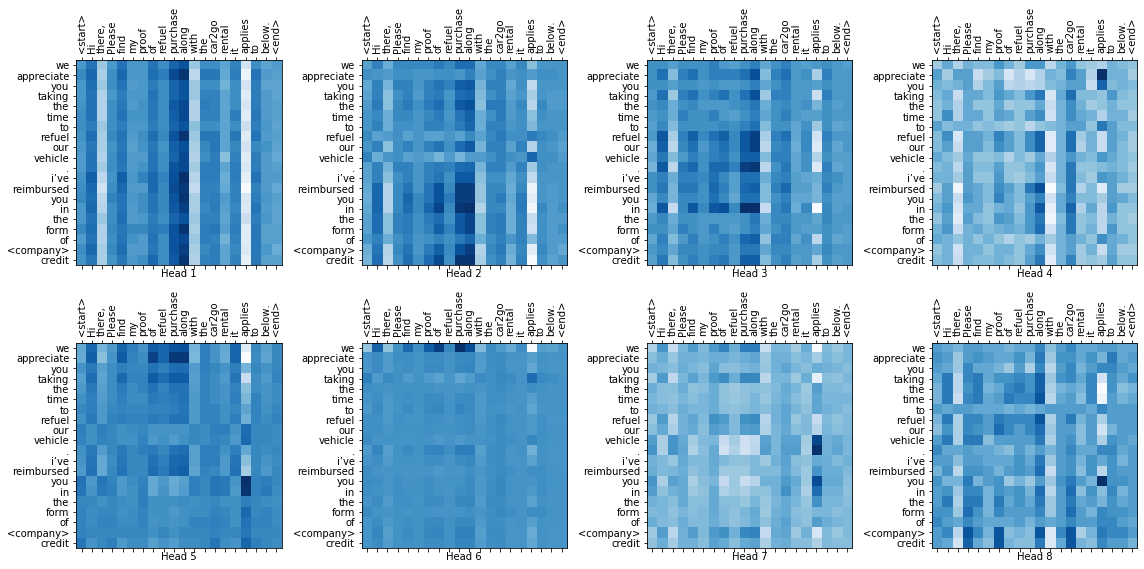

In [43]:
respondTR('Hi there, Please find my proof of refuel purchase along with the car2go rental it applies to below.',plot='decoder_layer5_block2')

Input: Hi there, Please find my proof of refuel purchase along with the car2go rental it applies to below.
Predicted Response: we appreciate you taking the time to refuel our car! unfortunately, the receipt provided is pre-authorized. to receive a refund, you must provide the receipt issued after completing the refuel <end>


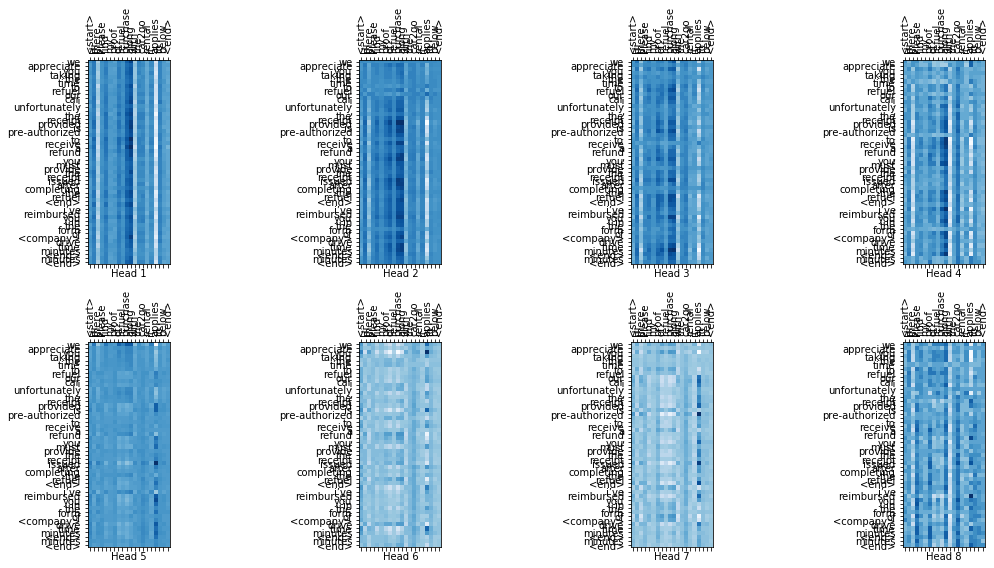

In [42]:
respond_beam('Hi there, Please find my proof of refuel purchase along with the car2go rental it applies to below.',2,plot='decoder_layer5_block2')